In [ ]:
#!pip install python-dateutil==2.5.0
#!pip install pandas --ignore-installed
#!pip install seaborn --ignore-installed

In [35]:
import sys
sys.path.append('../../')

import pandas as pd
import seaborn as sns
import numpy as np
from bemppUQ.utils.mie import bhmie
from bemppUQ.config import config

def tensorize(x1, x2=None):
    if x2 is None:
        x2 = x1
    
    x1 = np.array([x1])
    x2 = np.array([x2])
    return np.dot(x1.T, x2)

number_of_angles = 3601

angles = config['angles']
k_ext, k_int = config["k_ext"], config["k_int"]
lambda_par, freq = config["lambda"], config["frequency"]
polarization = config["polarization"]
direction = config["direction"]

eps_rel = config["eps_rel"]
mu_rel = config["mu_rel"]

n = k_int / k_ext
refIndex = n
numAngles = 901
s1,s2,qext,qsca,qback,gsca=bhmie(k_ext,k_int / k_ext,numAngles)

u =  4 * np.pi * s1
precision_list = [1, 2, 5, 10, 20, 30, 40, 50,60]

uh_list = []
h_list = []
N_list = []

for precision in precision_list:
    name = (
    "results/"
        + "precision"
    + str(precision)
    )

    my_dict = np.load(name + '.npy', allow_pickle = True, encoding = 'latin1')
    
    uh = my_dict.item().get('A22')[:1801]
    h = my_dict.item().get('h')
    N = my_dict.item().get('N')
    
    uh_list.append(uh)
    h_list.append(h)
    N_list.append(N)
    
    

df = pd.DataFrame(columns = ['precision', 'angle', 'cs', 'case', 'h'])

i = 0
err = []
Err = []

for precision in precision_list:
    uh = uh_list[i]
    
    h = h_list[i]
       
    
    U = tensorize(u, u)
    Uh = tensorize(uh, uh)
    
    rel_error = np.linalg.norm(uh - u) / np.linalg.norm(u)
    Rel_error = np.linalg.norm(Uh - U) / np.linalg.norm(U)
    
    err.append(rel_error)
    Err.append(Rel_error)
    
    i += 1
    
    print(rel_error, Rel_error, h)
    
err = np.array(err)
Err = np.array(Err)
h_list = np.array(h_list)    

0.5880545206118104 0.8215142925897863 1.2566370614359172
0.21898759975008292 0.3704077278521307 0.6283185307179586
0.03829244901115987 0.07035427134944416 0.25132741228718347
0.011635985407920544 0.021578265038604424 0.12566370614359174
0.003144839805057819 0.005836315836055584 0.06283185307179587
0.001382547055751161 0.0025680127219917465 0.041887902047863905
0.0007856845716162069 0.0014640098697467291 0.031415926535897934
0.0004939656754925588 0.0009193665398089902 0.025132741228718346
0.0003426220309920354 0.0006403655277804302 0.020943951023931952


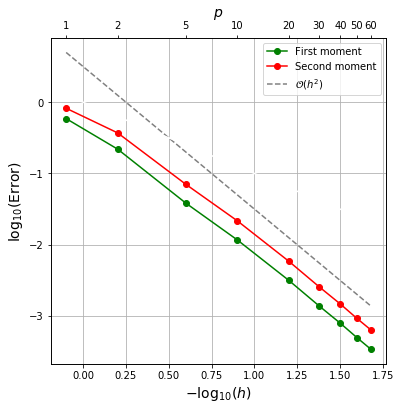

In [37]:
from matplotlib import pyplot as plt 

fig, ax  = plt.subplots(1,1, figsize=(6,6))

logh = np.log10(h_list)
logerr = np.log10(err)
Logerr = np.log10(Err)

ax.plot(-logh, logerr, marker='o', label = 'First moment', color = 'g')
ax.plot(-logh, Logerr, marker='o', label = 'Second moment', color = 'r')
ax.plot(-logh,  .5 + 2 * logh, color = 'gray', linestyle= '--', label = r'$\mathcal{O}(h^2)$')

#plt.loglog(1/h_list,  1.5 * h_list ** 2, color = 'gray', linestyle= '--')

ax2 = ax.twiny()

ax2.plot(-logh, logh, color='w')
ax2.set_xticks(-logh)
ax2.set_xticklabels(precision_list)

ax.legend()#prop={'size': 14})
ax.grid()
#plt.grid(color='gray', linestyle='dashed', which='both')
ax.set_xlabel(r'$-\log_{10}(h)$', fontsize=14)
ax2.set_xlabel(r'$p$', fontsize=14)
ax.set_ylabel(r'$\log_{10}($Error$)$', fontsize=14)

#plt.tight_layout()
plt.savefig('plots/FirstSecond.pdf')

In [38]:

def get_error(L0, L):
    n = 1801
    Sigma_hat = np.zeros([n, n], dtype=np.complex128)
    N_hat = 0
    N_max = 0

    for l in range(0, L+1-L0):   
        i0 = L0 + l
        i1 = L - l
        N0 = N_list[i0]
        N1 = N_list[i1]
        u0 = uh_list[i0]
        u1 = uh_list[i1]

        Sigma_hat += np.dot(np.array([u0]).T, np.array([u1]))

        N_hat += N0 * N1
        N_max = np.max([N_max, N0 * N1])


    for l in range(0, L-L0):
        i0 = L0 + l
        i1 = L - l - 1 
        N0 = N_list[i0]
        N1 = N_list[i1]

        u0 = uh_list[i0]
        u1 = uh_list[i1]

        Sigma_hat -= np.dot(np.array([u0]).T, np.array([u1]))
        
        N_hat += N0 * N1
        N_max = np.max([N_max, N0 * N1])
        
    Sigma = tensorize(u, u)

    notnan = np.where(~np.isnan(Sigma_hat))

    Sigma_hat = Sigma_hat[notnan]
    Sigma = Sigma[notnan]

    Error = np.linalg.norm(Sigma_hat - Sigma) / np.linalg.norm(Sigma)
    return Error, N_hat, N_max
        

In [39]:
Lmax = len(precision_list)
L0 = 1


Err_hat = []
h_S = []
N_hat_list = []
N_max_list = []

for l in range(L0, Lmax):
    h_S.append(h_list[l])
    Error, N_hat, N_max = get_error(L0, l)
    Err_hat.append(Error)
    N_hat_list.append(N_hat)
    N_max_list.append(N_max)

In [40]:
h_S = np.array(h_S)
Err_hat = np.array(Err_hat)

N_list = np.array(N_list)
N_hat_list = np.array(N_hat_list)
N_max_list = np.array(N_max_list)
print(h_S, Err_hat)

[0.62831853 0.25132741 0.12566371 0.06283185 0.0418879  0.03141593
 0.02513274 0.02094395] [0.37040773 0.09705508 0.03084559 0.00978677 0.00374926 0.00187952
 0.00110612 0.00073289]


Text(0, 0.5, '$\\log_{10}($Error$)$')

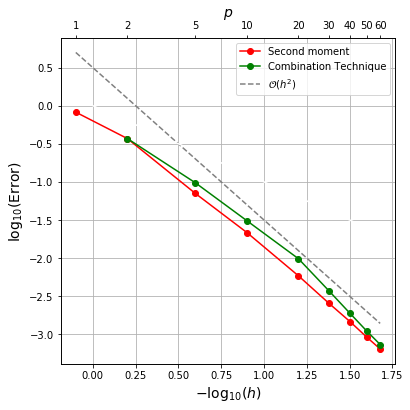

In [41]:
from matplotlib import pyplot as plt 

fig, ax  = plt.subplots(1,1, figsize=(6,6))
logh_S = np.log10(h_S)
Logerr_hat = np.log10(Err_hat)

ax.plot(-logh, Logerr, marker='o', label = 'Second moment', color = 'r')

ax.plot(-logh_S, Logerr_hat, marker='o', label = 'Combination Technique', color = 'g')


ax.plot(-logh,  .5 + 2 * logh, color = 'gray', linestyle= '--', label = r'$\mathcal{O}(h^2)$')

#plt.loglog(1/h_list,  1.5 * h_list ** 2, color = 'gray', linestyle= '--')

ax2 = ax.twiny()

ax2.plot(-logh, logh, color='w')
ax2.set_xticks(-logh)
ax2.set_xticklabels(precision_list)

ax.legend()#prop={'size': 14})
ax.grid()
#plt.grid(color='gray', linestyle='dashed', which='both')
ax.set_xlabel(r'$-\log_{10}(h)$', fontsize=14)
ax2.set_xlabel(r'$p$', fontsize=14)
ax.set_ylabel(r'$\log_{10}($Error$)$', fontsize=14)


In [45]:
logN2

array([ 4.31672498,  5.06805221,  6.55842103,  7.61344501,  8.74198787,
        9.44910877,  9.92010396, 10.31936293, 10.62025609])

Text(0, 0.5, '$\\log_{10}($Error$)$')

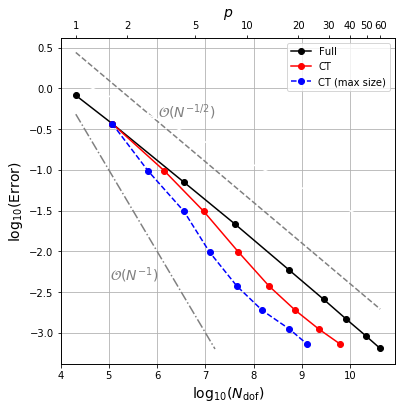

In [73]:
from matplotlib import pyplot as plt 

fig, ax  = plt.subplots(1,1, figsize=(6,6))
logh_S = np.log10(h_S)
Logerr_hat = np.log10(Err_hat)

logN_hat = np.log10(N_hat_list)
logN_max = np.log10(N_max_list)
N2 = N_list ** 2
logN2 = np.log10(N2)
logN2 = np.log10(N2)

ax.plot(logN2, Logerr, marker='o', label = 'Full', color = 'black')

ax.plot(logN_hat, Logerr_hat, marker='o', label = 'CT', color = 'r')

ax.plot(logN_max, Logerr_hat, marker='o', label = 'CT (max size)', color = 'b', linestyle='--')


ax.plot(logN2,  -logN2/2 + 2.6,  color = 'gray', linestyle= '--')#, label = )

test = np.array([ 4.31672498,  5.06805221,  6.55842103, 7.2])
ax.plot(test, -test +4,  color = 'gray', linestyle= 'dashdot')#, label = r'$\mathcal{O}(N^{-1})$')

plt.text(6.02,-.35,r'$\mathcal{O}(N^{-1/2})$', color='gray', fontsize=14)
plt.text(5.02,-2.35,r'$\mathcal{O}(N^{-1})$', color='gray', fontsize=14)

ax2 = ax.twiny()

ax2.plot(-logh, logh, color='w')
ax2.set_xticks(-logh)
ax2.set_xticklabels(precision_list)

ax.legend()#prop={'size': 14})
ax.grid()
#plt.grid(color='gray', linestyle='dashed', which='both')
ax.set_xlabel(r'$\log_{10}(N_\mathrm{dof})$', fontsize=14)
ax2.set_xlabel(r'$p$', fontsize=14)
ax.set_ylabel(r'$\log_{10}($Error$)$', fontsize=14)


In [11]:
Edof = Err[L0:] / N2[L0:]
Edof_hat = Err_hat / N_hat_list
Edof_max = Err_hat / N_max_list

In [12]:
compression_hat = Edof / Edof_hat
compression_max = Edof / Edof_max

In [13]:
print(compression_hat)
print(compression_max)


[1.         0.28412312 0.15846674 0.05233439 0.05044952 0.06853103]
[1.         0.13034302 0.06163103 0.01316572 0.01088298 0.01409644]
